### Testing Numpyro TP

In [59]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_formats = ["svg"]

from TProcess import *
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
numpyro.set_host_device_count(2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


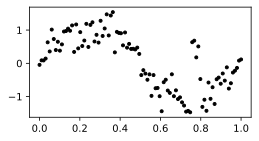

In [65]:
def generate_synthetic_data(key, n_points=30, noise_std=0.3, outlier_magnitude=1.0, num_outliers=5):
    X = jnp.linspace(0.0, jnp.pi * 2, n_points)[:, None]
    noise = jra.normal(key, X.shape) * noise_std
    Y = jnp.sin(X)
    Y = Y / jnp.abs(Y).max()
    Yc = Y.at[int(n_points*0.75):int(n_points*0.75)+num_outliers].add(outlier_magnitude) + noise
    X = X / X.max()
    return X, Y.reshape(-1), Yc.reshape(-1)

X_train, y_true, y_train = generate_synthetic_data(key=jra.PRNGKey(1), num_outliers=5, n_points=100)


# data = jnp.array([
#     [-5.007523737054322, -0.6204914810162654],
#     [-4.50602131396236, -0.9880736569298403],
#     [-3.257201859151617, 0.8942996399920982],
#     [-1.256231716680766, -0.4448474516173473],
#     [-0.753846980662134, -0.8793087449537689],
#     [-0.2591797186117839, -0.0006665781726113984],
#     [0.7417355749187164, -2.2504904065599423],
#     [2.4888588394405096, -0.013264070724962718],
#     [3.7428421552111706, 0.21172523724391779],
#     [-3.005982747197284, 1.1745485812553746]
# ])

# X_train, y_train = data[:, 0], data[:, 1]


fig, ax = plt.subplots(figsize=(4,2))
ax.plot(X_train, y_train, '.', label='Data', color='k')
# ax.plot(X_train, y_true, label='True function', color='blue')
plt.show()


In [61]:
# Initialize the model
tp = StudentTP(input_dim=1)

# Fit the model
rng_key = jra.PRNGKey(0)
tp.fit(rng_key, X_train, y_train, num_chains=2, num_warmup=1000, num_samples=1000)

# Make predictions
rng_key_pred = jra.PRNGKey(1)
X_test = jnp.linspace(jnp.min(X_train), jnp.max(X_train), 100)[:, None]
means, samples = tp.predict(rng_key_pred, X_test, num_draws=1)

# replace nans with the nanmean of samples
# samples = jnp.where(jnp.isnan(samples), jnp.nanmean(samples, axis=0), samples)


tp_mean_prediction = jnp.nanmean(means, axis=0)
tp_percentiles = jnp.percentile(samples.reshape(-1, X_test.shape[0]), 
                          jnp.array([2.5, 97.5]), axis=0)

sample: 100%|██████████| 2000/2000 [00:00<00:00, 3283.69it/s, 7 steps of size 5.52e-01. acc. prob=0.91]



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
      amplitude      0.54      0.10      0.54      0.38      0.70   1419.16      1.00
length_scale[0]      1.19      1.97      0.59      0.07      2.73   1189.74      1.00
          noise      0.18      0.08      0.17      0.05      0.31   2156.11      1.00
             nu      4.08      1.42      3.93      1.96      6.41   2176.31      1.00

Number of divergences: 0


In [66]:
gp = GaussianProcess(input_dim=1) #, noise_prior_dist=dist.Uniform(low=0.0, high=0.5))

# Fit
rng_key = jra.PRNGKey(0)
gp.fit(rng_key, X_train, y_train, num_chains=2, num_warmup=1000, num_samples=1000)

# Predict
rng_key_pred = jra.PRNGKey(1)
means, samples = gp.predict(rng_key_pred, X_test, num_draws=1)

gp_mean_prediction = jnp.mean(means, axis=0)
gp_percentiles = jnp.percentile(samples.reshape(-1, X_test.shape[0]), 
                          jnp.array([2.5, 97.5]), axis=0)

TypeError: squared_exponential_kernel() got an unexpected keyword argument 'noise'

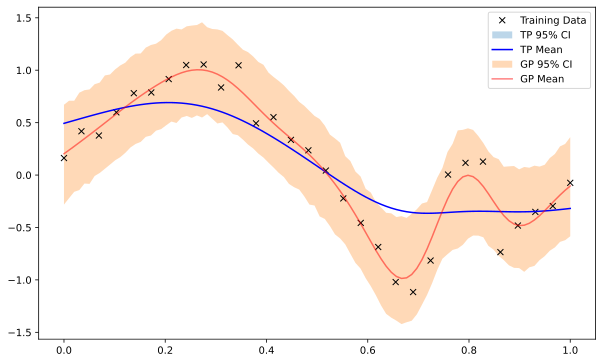

In [63]:
plt.figure(figsize=(10, 6))
plt.plot(X_train, y_train, 'kx', label='Training Data')
# plt.plot(X_train, y_true, 'k--', label='True Function')

plt.fill_between(X_test.squeeze(), tp_percentiles[0], tp_percentiles[1], 
               alpha=0.3, label='TP 95% CI')
plt.plot(X_test, tp_mean_prediction, 'b-', label='TP Mean')

plt.fill_between(X_test.squeeze(), gp_percentiles[0], gp_percentiles[1], 
               alpha=0.3, label='GP 95% CI')
plt.plot(X_test, gp_mean_prediction, 'r-', label='GP Mean', alpha=0.5)

plt.legend()
plt.show()

### Fitting the model to a benchmark dataset - well, some of it at least. 

In [64]:
import pandas as pd

df = pd.read_csv("data/AutoAM_dataset.csv")

X = jnp.array(df.iloc[:, :-1].values)
y = jnp.array(df.iloc[:, -1].values)

# normalize the X values to be between 0 and 1
# standardize the y values

X = (X - X.min()) / (X.max() - X.min())
y = (y - y.mean()) / y.std()

train_idx = jra.choice(jra.PRNGKey(0), X.shape[0], shape=(int(X.shape[0]*0.6),), replace=False)

Xdata_train, ydata_train = X[train_idx], y[train_idx]
Xdata_test, ydata_test = X[~jnp.isin(jnp.arange(X.shape[0]), train_idx)], y[~jnp.isin(jnp.arange(X.shape[0]), train_idx)]

tp = StudentTP(input_dim=X.shape[1])

rng_key = jra.PRNGKey(0)
tp.fit(rng_key, Xdata_train, ydata_train, num_chains=1, num_warmup=1000, num_samples=1000)

rng_key_pred = jra.PRNGKey(1)
means, samples = tp.predict(rng_key_pred, Xdata_test, num_draws=1)

tp_mean_prediction = jnp.mean(means, axis=0)
tp_percentiles = jnp.percentile(samples.reshape(-1, Xdata_test.shape[0]), 
                          jnp.array([2.5, 97.5]), axis=0)

NameError: name 'asdf' is not defined

In [46]:
gp = GaussianProcess(input_dim=X.shape[1])
rng_key = jra.PRNGKey(0)
gp.fit(rng_key, Xdata_train, ydata_train, num_chains=1, num_warmup=1000, num_samples=1000)
rng_key_pred = jra.PRNGKey(1)
means, samples = gp.predict(rng_key_pred, Xdata_test, num_draws=1)
gp_mean_prediction = jnp.mean(means, axis=0)
gp_percentiles = jnp.percentile(samples.reshape(-1, Xdata_test.shape[0]), 
                          jnp.array([2.5, 97.5]), axis=0)


sample: 100%|██████████| 2000/2000 [00:11<00:00, 173.80it/s, 15 steps of size 2.76e-01. acc. prob=0.94]



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
      amplitude      1.70      0.44      1.63      1.08      2.32    608.95      1.00
length_scale[0]      1.31      2.03      0.73      0.20      2.60    558.82      1.00
length_scale[1]      0.47      0.62      0.35      0.15      0.72    190.85      1.00
length_scale[2]      0.05      0.01      0.05      0.03      0.07    634.34      1.00
length_scale[3]      0.18      0.11      0.15      0.08      0.32    309.04      1.00
          noise      0.22      0.04      0.21      0.15      0.28    479.00      1.00

Number of divergences: 0


TP ERROR: 0.473657
GP ERROR: 0.33649513


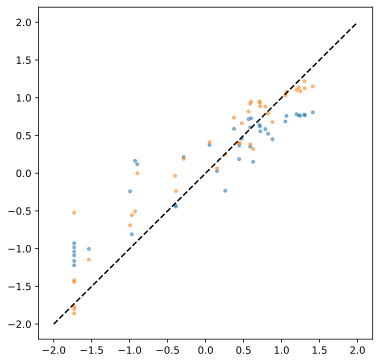

In [47]:
# print the RMSE
print("TP ERROR:", jnp.sqrt(jnp.mean((tp_mean_prediction - ydata_test)**2)))
print("GP ERROR:", jnp.sqrt(jnp.mean((gp_mean_prediction - ydata_test)**2)))

fig, ax = plt.subplots(figsize=(6, 6))
plt.plot(ydata_test, tp_mean_prediction, '.', alpha=0.5)
plt.plot(ydata_test, gp_mean_prediction, '.', alpha=0.5)
plt.plot([-2, 2], [-2, 2], 'k--')
plt.show()